<a href="https://colab.research.google.com/github/kundajelab/dragonn/blob/master/paper_supplement/PrimerTutorial%205%20-%20Functional%20variant%20characterization%20for%20non-coding%20SNPs%20within%20the%20SPI1%20motif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# add in predictions on bQTL's. (preactivation)
# Minor allele frequency list for bQTL SNPs (Yoruban)

#Visualizations: 
# Confusion matrix representation (observed: -1, 0, +1 vs predicted -1, 0 ,+1)
## * include all SNPs 
## * bQTL's will fall in +/-1 bins 
# Enrichment curves: model vs motifs 
# Scatterplot: model vs motifs 

#Weak affinity vs strong affinity (examples : SNP disrupts motif center, SNP disrupts flanking region) 

# How to train your DragoNN tutorial 5: 
## Functional variant characterization for non-coding SNPs within the SPI1 motif 

This tutorial is a supplement to the DragoNN manuscript. 

This tutorial will take 2 - 3 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data: SPI1 ChiP-seq and experimental bQTL data</a></li>
    <li><a href=#2>Genomewide classification and regression labels for SPI1 TF ChiPseq</a></li>
    <li><a href=#3>Optional: Download pre-generated models and test-set predictions</a></li>
    <li><a href=#4>Genome-wide classification for SPI1</a></li>
    <li><a href=#5>Calibrate model predictions with Platt Scaling</a></li>
    <li><a href=#6>Genome-wide regression for SPI1</a></li> 
    <li><a href=#7>Calibrate model predictions with Isotonic Regression</a></li> 
    <li><a href=#8>Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT</a></li>
    <li><a href=#9>Recovering bQTL effect sizes: Classification vs Regression</a></li>
    <li><a href=#10>Model-predicted SNP effect sizes vs bQTL effect sizes</a></li>
    <li><a href=#11>Conclusions</a></li>    
    <li><a href=#12>Save tutorial outputs</a></li>
</ol>
Github issues on the [dragonn repository](https://github.com/kundajelab/dragonn) with feedback, questions, and discussion are always welcome.


In [2]:
# If you don't have bedtools installed in your environment (i.e. Google Colab), uncomment and run the command below 
#!apt-get install bedtools
#!pip install pybedtools

In [3]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install dragonn>=0.2.6

In [4]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [5]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *

Using TensorFlow backend.
/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Input data <a name='1'>
<a href=#outline>Home</a>

This tutorial uses the same in vivo SPI1 transcription factor CHiP-seq dataset that was used in [Tutorial 4](https://colab.research.google.com/github/kundajelab/dragonn/blob/keras_2.2_tensorflow_1.6_purekeras/paper_supplement/PrimerTutorial%204%20-%20Interpreting%20predictive%20sequence%20features%20in%20in-vivo%20TF%20binding%20events.ipynb). Our goal is to compare predicted variant effect sizes from classification and regression models against experimental bQTL data. The bQTL data in this way serves as a "gold-standard" validation that in silico mutagenesis on the deep learning inputs leads to correct variant effect size prediction.  We  will use bQTL data  that has been intersected with SPI1 CISBP genome motif annotations. 

In [6]:
# SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
!wget -O SPI1.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz

#Fold change bigWig track for the SPI1 dataset: 
!wget -O SPI1.pooled.fc.bigWig http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-macs2_pooled/execution/ENCFF000OBU.Rep1.merged.nodup.pooled_x_ENCFF000OCW.Control.Rep1.merged.nodup.fc.signal.bigwig
    
## Download "ambiguous" peak sets -- these peaks are in the optimal overlap set across replicates, but are not
## found to be reproducible at a high confidence (p<0.05) by IDR 
! wget -O SPI1.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.ambiguous.gz

## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.fai 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.gzi 

    




--2019-03-02 17:19:02--  http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 693298 (677K) [application/x-gzip]
Saving to: ‘SPI1.narrowPeak.gz’

SPI1.narrowPeak.gz  100%[===================>] 677.05K  --.-KB/s    in 0.02s   

2019-03-02 17:19:02 (39.3 MB/s) - ‘SPI1.narrowPeak.gz’ saved [693298/693298]

--2019-03-02 17:19:02--  http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-macs2_pooled/execution/ENCFF000OBU.Rep1.merged.nodup.pooled_x_ENCFF000OCW.Control.Rep1.merged.nodup.fc.signal.bigwig
Resolving mitra.stanf

In [7]:
# Download bQTL experimental data for SPI1 loci 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.txt.gz

--2019-03-02 17:19:34--  http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.txt.gz
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23850031 (23M) [application/x-gzip]
Saving to: ‘SPI1.bQTLs.txt.gz’

SPI1.bQTLs.txt.gz   100%[===================>]  22.75M  43.5MB/s    in 0.5s    

2019-03-02 17:19:35 (43.5 MB/s) - ‘SPI1.bQTLs.txt.gz’ saved [23850031/23850031]



## Generating genome-wide classification and regression labels <a name='2'>
<a href=#outline>Home</a>

We will use the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. We will treat each sample as a task for the model and compare the performance of the model on SPI1 task in the single-tasked and multi-tasked setting.

In [10]:
from seqdataloader import * 

In [11]:
## seqdataloader accepts an input file, which we call SPI1.tasks.tsv, with task names in column 1, corresponding
## peak files in column 2, and the signal track in column 3. In this tutorial, the task file will have a single task entry for the SPI1 TF CHiP-seq
with open("SPI1.task.tsv",'w') as f: 
    f.write("SPI1\tSPI1.narrowPeak.gz\tSPI1.pooled.fc.bigWig\tSPI1.ambiguous.gz\n")
f.close() 
!cat SPI1.task.tsv

SPI1	SPI1.narrowPeak.gz	SPI1.pooled.fc.bigWig	SPI1.ambiguous.gz


With the parameter configuration below, seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* In the classification case, each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. The bin is labeled negative if there is no overlap with the narrowPeak. 
* In the regression case, the asinh(mean coverage) in the 200 bp bin is computed. 


**Note**: The label generation may take 10 - 15 minutes to complete. If you prefer not to wait, you can download the 
pre-generated classification and regression labels for the training, validation, and test sets by uncommenting the code below: 

In [ ]:
## Classification labels 
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.classification.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.classification.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.classification.hdf5

## Regression labels 
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.regression.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.regression.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.regression.hdf5


If you prefer to generate the labels from scratch, execute the two code cell below: 

In [12]:
#  Generate genome-wide classification labels 

#1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set. Also, the dataset does not
# include chromosome Y, so we exclude it as well. 

train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(test_set_params)


creating dictionary of bed files and bigwig files for each task:
SPI1
creating chromosome thread pool
launching thread pool
pre-allocated df for chrom:chr9with dimensions:(2824249, 4)
pre-allocated df for chrom:chr7with dimensions:(3182754, 4)
pre-allocated df for chrom:chr5with dimensions:(3618286, 4)
got peak subset for chrom:chr9 for task:SPI1
finished chromosome:chr9 for task:SPI1
got peak subset for chrom:chr7 for task:SPI1
got peak subset for chrom:chr5 for task:SPI1
finished chromosome:chr7 for task:SPI1
pre-allocated df for chrom:chr3with dimensions:(3960429, 4)
finished chromosome:chr5 for task:SPI1
got peak subset for chrom:chr3 for task:SPI1
finished chromosome:chr3 for task:SPI1
pre-allocated df for chrom:chr10with dimensions:(2710675, 4)
pre-allocated df for chrom:chr8with dimensions:(2927261, 4)
got peak subset for chrom:chr10 for task:SPI1
finished chromosome:chr10 for task:SPI1
pre-allocated df for chrom:chr6with dimensions:(3422282, 4)
got peak subset for chrom:chr8 fo

In [13]:
# Generate regression labels genome-wide 

#1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set 

train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(test_set_params)


creating dictionary of bed files and bigwig files for each task:
SPI1
creating chromosome thread pool
launching thread pool
pre-allocated df for chrom:chr9with dimensions:(2824249, 4)
pre-allocated df for chrom:chr7with dimensions:(3182754, 4)
starting chromosome:chr9 for task:SPI1
starting chromosome:chr7 for task:SPI1
pre-allocated df for chrom:chr5with dimensions:(3618286, 4)
starting chromosome:chr5 for task:SPI1
pre-allocated df for chrom:chr3with dimensions:(3960429, 4)
starting chromosome:chr3 for task:SPI1
finished chromosome:chr9 for task:SPI1
finished chromosome:chr7 for task:SPI1
finished chromosome:chr5 for task:SPI1
finished chromosome:chr3 for task:SPI1
pre-allocated df for chrom:chr10with dimensions:(2710675, 4)
starting chromosome:chr10 for task:SPI1
pre-allocated df for chrom:chr8with dimensions:(2927261, 4)
starting chromosome:chr8 for task:SPI1
pre-allocated df for chrom:chr6with dimensions:(3422282, 4)
starting chromosome:chr6 for task:SPI1
finished chromosome:chr10

Let's examine the files that were generated: 

In [14]:
#The code generates bed file outputs with a label of 1 or 0 for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
pd.read_hdf("SPI1.train.classification.hdf5",start=1000000,stop=1000010)

SPI1
CHR  START    END           
chr3 50000000 50001000   0.0
     50000050 50001050   0.0
     50000100 50001100   0.0
     50000150 50001150   0.0
     50000200 50001200   0.0
     50000250 50001250   0.0
     50000300 50001300   0.0
     50000350 50001350   0.0
     50000400 50001400   0.0
     50000450 50001450   0.0

In [15]:
pd.read_hdf("SPI1.train.regression.hdf5",start=1000000,stop=1000010)

SPI1
CHR  START    END               
chr3 50000000 50001000  0.287037
     50000050 50001050  0.436855
     50000100 50001100  0.491599
     50000150 50001150  0.460063
     50000200 50001200  0.460063
     50000250 50001250  0.460063
     50000300 50001300  0.491599
     50000350 50001350  0.519880
     50000400 50001400  0.633077
     50000450 50001450  0.709212

## Optional: Download pre-generated models and test-set predictions <a name='3'>
<a href=#outline>Home</a>

Next, we will train classification and regression models to predict TF CHiP-seq peaks for SPI1. If you want to skip straight to model interpretation and bQTL analysis, you can download the pre-trained models by uncommenting the 
block of code below. 

In [7]:
from keras.models import load_model 

## Download classification model 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5
#spi1_classification_model=load_model("SPI1.classification.model.hdf5")

## Download regression model 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
#spi1_regression_model=load_model("SPI1.regression.model.hdf5")


## Get test set classification model and regression model predictions 
#import h5py
#test_set_predictions=h5py.File("SPI1.test.predictions.hdf5")
#spi1_test_classification_predictions=test_set_predictions['classification'].value 
#spi1_test_regression_predictions=test_set_predictions['regression'].value 

## Genome-wide classification model <a name='4'>
<a href=#outline>Home</a>


In [16]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')

In [20]:
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from keras.constraints import max_norm
from dragonn.custom_losses import get_ambig_binary_crossentropy
def initialize_classification_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))
    
    #use the custom ambig_binary_crossentropy loss, indicating that a value of np.nan indicates an ambiguous label 
    loss=get_ambig_binary_crossentropy()
    
    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam', loss=loss,
                  metrics=[tpr,
                           tnr,
                           fpr,
                           fnr,
                           precision,
                           f1])
    return model

We create generators for the training and validation data: 

In [26]:
#create the generators, upsample positives to ensure they constitute 30% of each batch 
from dragonn.generators import * 
spi1_train_classification_gen=DataGenerator("SPI1.train.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3, batch_size=256)
spi1_valid_classification_gen=DataGenerator("SPI1.valid.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.01, batch_size=256)


In [27]:
#Train the SPI1 classification model 
spi1_classification_model=initialize_classification_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_classification=spi1_classification_model.fit_generator(spi1_train_classification_gen,
                                                  validation_data=spi1_valid_classification_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 550s 55ms/step - loss: 0.1399 - sensitivity: 0.9140 - specificity: 0.9584 - fpr: 0.0416 - fnr: 0.0860 - precision: 0.9024 - f1: 0.9073 - val_loss: 0.0920 - val_sensitivity: 0.8914 - val_specificity: 0.9671 - val_fpr: 0.0329 - val_fnr: 0.1086 - val_precision: 0.2012 - val_f1: nan
Epoch 2/150
10000/10000 [==============================] - 522s 52ms/step - loss: 0.0970 - sensitivity: 0.9531 - specificity: 0.9687 - fpr: 0.0313 - fnr: 0.0469 - precision: 0.9288 - f1: 0.9404 - val_loss: 0.1186 - val_sensitivity: 0.9369 - val_specificity: 0.9503 - val_fpr: 0.0497 - val_fnr: 0.0631 - val_precision: 0.1429 - val_f1: nan
Epoch 3/150
10000/10000 [==============================] - 522s 52ms/step - loss: 0.0827 - sensitivity: 0.9658 - specificity: 0.9720 - fpr: 0.0280 - fnr: 0.0342 - precision: 0.9366 - f1: 0.9506 - val_loss: 0.0931 - val_sensitivity: 0.9127 - val_specificity: 0.9618 - val_fpr: 0.0382 - val_fnr: 0.0873 - val_precision: 0.17

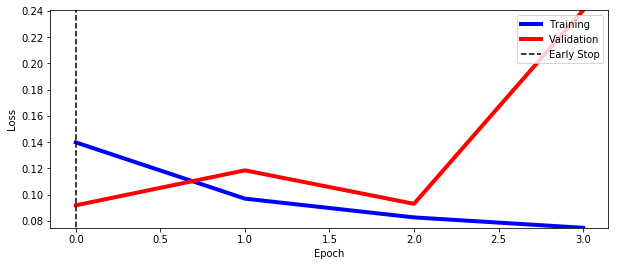

In [28]:
## Plot the learning curves for SPI1  
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_classification)

We now measure how well the model performed by calculating performance metrics on the test splits across the whole genome. 

In [29]:
from dragonn.generators import * 
spi1_test_classification_gen=DataGenerator("SPI1.test.classification.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_classification_predictions=spi1_classification_model.predict_generator(spi1_test_classification_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_classification_truth=spi1_test_classification_gen.data

6047/6047 [==============================] - 428s 71ms/step


In [40]:
spi1_test_classification_predictions.shape

(6046528, 1)

In [49]:
#remove nans, as they corresponnd to ambiguous values 
nan_indices=np.isnan(spi1_test_classification_truth['SPI1'])

In [50]:
spi1_test_classification_truth=spi1_test_classification_truth[~nan_indices]
spi1_test_classification_predictions=spi1_test_classification_predictions[~nan_indices]

In [51]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_classification_truth.values.astype(bool),spi1_test_classification_predictions))

Loss: 0.0886	Balanced Accuracy: 92.79%	 auROC: 0.986	 auPRC Careful: 0.375	 auPRC Trapezoidal: 0.375
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|4.3%	 Num Positives: 20574	 Num Negatives: 6015749


## Calibrate the model predictions with Platt scaling  <a name='5'>
<a href=#outline>Home</a>

In [52]:
from scipy.special import logit,expit 
spi1_test_classification_logits=logit(spi1_test_classification_predictions)

In [53]:
import abstention 
from abstention.calibration import PlattScaling, IsotonicRegression 

In [54]:
classification_calibration_func = PlattScaling()(
                            valid_preacts=spi1_test_classification_logits,
                            valid_labels=spi1_test_classification_truth)


Platt scaling coef: 1.034707675160267 ; intercept: -4.429173183942388


In [55]:
spi1_test_classification_predictions_calibrated=classification_calibration_func(spi1_test_classification_logits)

In [69]:
## Generate a ClassificationResult object on calibrated model predictions 
print(ClassificationResult(spi1_test_classification_truth.values.astype(bool),
                           np.expand_dims(spi1_test_classification_predictions_calibrated,axis=1)))

Loss: 0.0107	Balanced Accuracy: 60.55%	 auROC: 0.986	 auPRC Careful: 0.375	 auPRC Trapezoidal: 0.375
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|4.3%	 Num Positives: 20574	 Num Negatives: 6015749


## Genome-wide regression model <a name='6'>
<a href=#outline>Home</a>

In [70]:
def initialize_regression_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))


    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='mse')
    return model

(4010730, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f793fcda128>]],
      dtype=object)

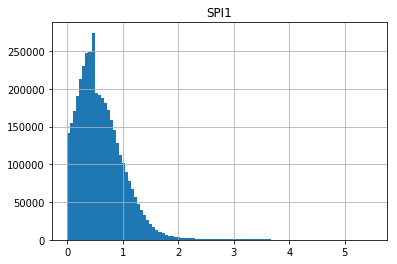

In [57]:
#we want to determine a threshold for upsampling the non-zero bins in a given batch 
# extract 5 million datapoints from the training data and observe the distribution of non-zero signal values  
sample=pd.read_hdf("SPI1.train.regression.hdf5",start=0,stop=5000000)
nonzero_sample=sample[sample.max(axis=1)>0]
print(nonzero_sample.shape)
nonzero_sample.hist(bins=100)

This suggests that 1 is a reasonable threshold for upsampling signal bins in regression 

In [71]:
#create the generators, no upsampling of positives is used for regression. 
from dragonn.generators import * 
spi1_train_regression_gen=DataGenerator("SPI1.train.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=1)
spi1_valid_regression_gen=DataGenerator("SPI1.valid.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.01,upsample_thresh=1)


In [72]:
#Train the SPI1 regression model 
spi1_regression_model=initialize_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_regression=spi1_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 303s 30ms/step - loss: 0.2425 - val_loss: 0.1300
Epoch 2/150
10000/10000 [==============================] - 295s 29ms/step - loss: 0.1988 - val_loss: 0.1299
Epoch 3/150
10000/10000 [==============================] - 296s 30ms/step - loss: 0.1920 - val_loss: 0.1383
Epoch 4/150
10000/10000 [==============================] - 296s 30ms/step - loss: 0.1894 - val_loss: 0.1445
Epoch 5/150
10000/10000 [==============================] - 293s 29ms/step - loss: 0.1875 - val_loss: 0.0988
Epoch 6/150
10000/10000 [==============================] - 294s 29ms/step - loss: 0.1859 - val_loss: 0.1275
Epoch 7/150
10000/10000 [==============================] - 295s 30ms/step - loss: 0.1859 - val_loss: 0.1434
Epoch 8/150
10000/10000 [==============================] - 294s 29ms/step - loss: 0.1845 - val_loss: 0.1487
Epoch 1/150


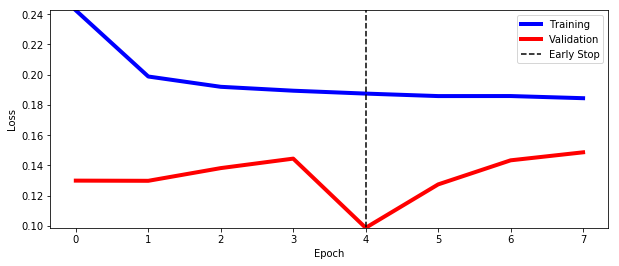

In [73]:
plot_learning_curve(history_regression)

In [74]:
from dragonn.generators import * 
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 496s 82ms/step


In [85]:
#remove nans, as they corresponnd to ambiguous values 
spi1_test_regression_truth=spi1_test_regression_truth[~nan_indices]
spi1_test_regression_predictions=spi1_test_regression_predictions[~nan_indices]

In [86]:
spi1_test_regression_predictions.shape

(6036323, 1)

## Regression model calibration with Isotonic Regression  <a name='7'>
<a href=#outline>Home</a>

In [88]:
regression_calibration_func = IsotonicRegression()(
    valid_preacts=spi1_test_regression_predictions,
    valid_labels=spi1_test_regression_truth['SPI1'])

In [89]:
spi1_test_regression_predictions_calibrated=regression_calibration_func(spi1_test_regression_predictions)

In [95]:
spi1_test_regression_predictions_calibrated=np.expand_dims(spi1_test_regression_predictions_calibrated,axis=1)

In [96]:
## find the indices of the non-zero coverage bins 
nonzero_bins=spi1_test_regression_truth.max(axis=1)>0

In [97]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions_calibrated)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions_calibrated)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.58533401]), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.548537581133218, pvalue=0.0)


In [98]:
# Calculate the spearman and pearson correlation, restricted to non-zero bins 
corr_pearson_nonzero_bins=pearsonr(spi1_test_regression_truth[nonzero_bins],spi1_test_regression_predictions_calibrated[nonzero_bins])
corr_spearman_nonzero_bins=spearmanr(spi1_test_regression_truth[nonzero_bins],spi1_test_regression_predictions_calibrated[nonzero_bins])
print("Pearson correlation on test set:"+str(corr_pearson_nonzero_bins))
print("Spearman correlation on test set:"+str(corr_spearman_nonzero_bins))

Pearson correlation on test set:(array([0.53627413]), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.4510345212324681, pvalue=0.0)


In [99]:
spi1_test_regression_truth.values[0:10].squeeze()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [100]:
test_df=pd.DataFrame({"Observed":list(spi1_test_regression_truth.values.squeeze()),
                     "Predicted":list(spi1_test_regression_predictions_calibrated.squeeze())})

In [101]:
test_df_nonzero=pd.DataFrame({"Observed":list(spi1_test_regression_truth[nonzero_bins].values.squeeze()),
                     "Predicted":list(spi1_test_regression_predictions_calibrated[nonzero_bins].squeeze())})

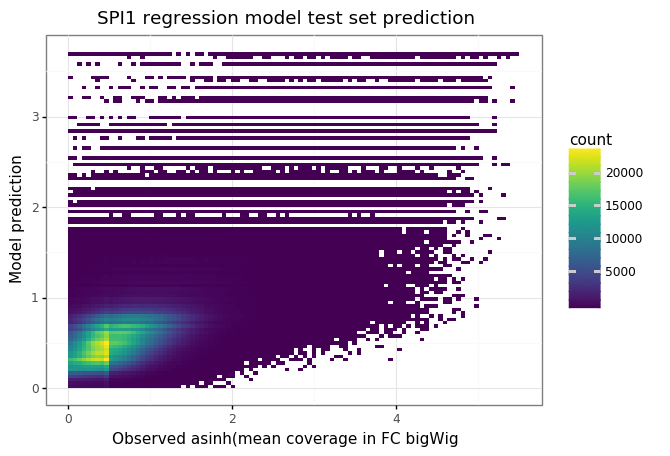

<ggplot: (8759890019290)>


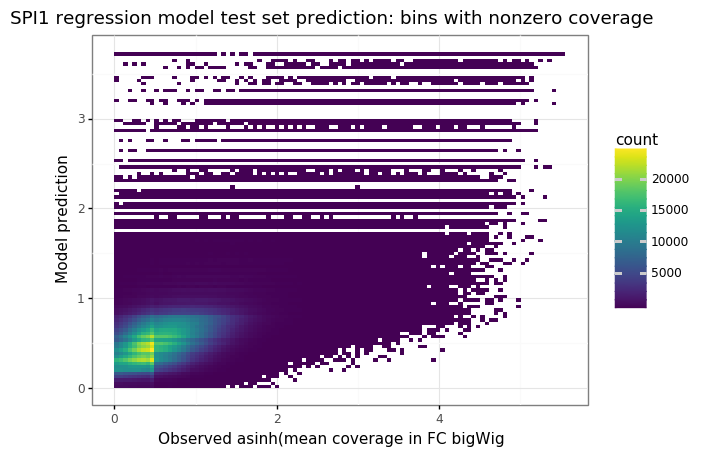

<ggplot: (-9223363276976852550)>


In [102]:
import plotnine 
from plotnine import * 
print((ggplot(test_df,aes(x="Observed",y="Predicted"))
 +geom_bin2d(bins=100)
 +theme_bw()
 +xlab("Observed asinh(mean coverage in FC bigWig")
 +ylab("Model prediction")
 +ggtitle("SPI1 regression model test set prediction")))

print((ggplot(test_df_nonzero,aes(x="Observed",y="Predicted"))
 +geom_bin2d(bins=100)
 +theme_bw()
 +xlab("Observed asinh(mean coverage in FC bigWig")
 +ylab("Model prediction")
 +ggtitle("SPI1 regression model test set prediction: bins with nonzero coverage")))

## Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT <a name='8'>
<a href=#outline>Home</a>

### Classification Model

In [ ]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence true positive predictions)
spi1_test_classification_truth_bool=spi1_test_classification_truth.values.astype(bool)
true_pos_spi1=spi1_test_classification_truth[spi1_test_classification_truth_bool*spi1_test_classification_predictions_calibrated >0.9]
true_pos_spi1.head

In [ ]:
from dragonn.utils import one_hot_from_bed
deep_lift_input_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
deep_lift_input_spi1.shape

In [ ]:
from dragonn.tutorial_utils import deeplift 

In [ ]:
deep_lift_scores_spi1=deeplift(spi1_classification_model,deep_lift_input_spi1)

In [ ]:
deep_lift_scores_spi1.shape

Let's plot a few of the DeepLIFT tracks and see if the model successfully learned SPI1:

In [ ]:
from dragonn.tutorial_utils import  plot_seq_importance

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input_spi1[2])

Let's zoom in to the center of one sequence so that it is easier to distinguish the motif: 

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[2].squeeze()[550:650],deep_lift_input_spi1[2].squeeze()[550:650])

If we query the sequence "CACTTCCCCT" in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we find that the motif is a good match for SPIB: 
<img src="https://github.com/kundajelab/dragonn/blob/master/paper_supplement/tutorial_images/SPI1.Tut4.png?raw=1" alt="SPI12TomTom" width="400"/>


### Regression model 

In [ ]:
#Sanity-check that the model is learning the SPI1 motif by running DeepLIFT on True Positives with high confidence (>0.9)
#get the true positive predictions 
true_pos=spi1_test_regression_truth[(spi1_test_regression_truth.values*spi1_test_regression_predictions_calibrated)>2]
true_pos.shape

In [ ]:
deep_lift_input=one_hot_from_bed([i for i in true_pos.index],"hg19.genome.fa.gz")
deep_lift_input.shape

In [ ]:
help(deeplift)

In [ ]:
deep_lift_scores_spi1=deeplift(spi1_regression_model,deep_lift_input_spi1,target_layer_idx=-1)

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input_spi1[2])

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[2].squeeze()[550:650],deep_lift_input_spi1[2].squeeze()[550:650])

The motif learned by the regression model matches the canonical SPI1 motif, though the deepLIFT tracks are noisier compared to those for the classification model. 


## Recovering bQTL effect sizes: Classification vs Regression <a name='7'>
<a href=#outline>Home</a>

In [114]:
from dragonn.generators import * 
bqtl_ref_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","POSTallele")
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","ALTallele")

In [148]:
bqtl_ref_gen.data

,,,ALTdepth,REFDepth,ALTallele,POSTallele,POSTfreq,prechipfreq,pvalue
Chr,position,Depth,,,,,,,
chr17,18967176,538,418,120,G,A,0.223048,0.866699,2.331853e-251
chr4,176935913,626,597,29,A,C,0.046326,0.543949,4.449643e-162
chr1,144534083,618,368,250,T,C,0.404531,0.057295,5.863065e-141
chr17,19015381,144,143,1,A,T,0.006944,0.872850,1.040250e-126
chr1,17231724,2477,1321,1156,G,A,0.466694,0.255195,9.915948e-114
chr16,87705494,115,105,10,G,C,0.086957,0.934802,1.195059e-111
chr12,16789835,483,75,408,T,C,0.844720,0.355177,4.004184e-109
chr6,4154143,361,341,20,G,A,0.055402,0.600680,1.485270e-108
chr15,70174409,264,226,38,T,C,0.143939,0.775476,1.982983e-105


In [115]:
bqtl_ref_classification_predictions=spi1_classification_model.predict_generator(bqtl_ref_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)

7811/7811 [==============================] - 88s 11ms/step


In [116]:
bqtl_alt_classification_predictions=spi1_classification_model.predict_generator(bqtl_alt_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
bqtl_ref_classification_truth=bqtl_ref_gen.data['pvalue']
bqtl_ref_classification_truth=np.expand_dims(bqtl_ref_classification_truth,axis=1)

7811/7811 [==============================] - 89s 11ms/step


In [117]:
#sanity check the np.array shapes 
print(bqtl_ref_classification_predictions.shape)
print(bqtl_alt_classification_predictions.shape)
print(bqtl_ref_classification_truth.shape)

(999799, 1)
(999799, 1)
(999799, 1)


In [118]:
#get the pre-activations 
bqtl_ref_classification_logits=logit(bqtl_ref_classification_predictions)
bqtl_alt_classification_logits=logit(bqtl_alt_classification_predictions)


In [131]:
ref_max_allowed=np.nanmax(bqtl_ref_classification_logits[np.isfinite(bqtl_ref_classification_logits)])

In [132]:
ref_min_allowed=np.nanmin(bqtl_ref_classification_logits[np.isfinite(bqtl_ref_classification_logits)])

In [133]:
alt_max_allowed=np.nanmax(bqtl_alt_classification_logits[np.isfinite(bqtl_alt_classification_logits)])

In [134]:
alt_min_allowed=np.nanmin(bqtl_alt_classification_logits[np.isfinite(bqtl_alt_classification_logits)])

In [135]:
## replace any infinite values with the maximum/ minimum finite values in the arrays 
bqtl_ref_classification_logits[bqtl_ref_classification_logits > ref_max_allowed]=ref_max_allowed 
bqtl_ref_classification_logits[bqtl_ref_classification_logits < ref_min_allowed]=ref_min_allowed 
bqtl_alt_classification_logits[bqtl_alt_classification_logits > alt_max_allowed]=alt_max_allowed 
bqtl_alt_classification_logits[bqtl_alt_classification_logits < alt_min_allowed]=alt_min_allowed 


In [136]:
#calibrate predictions with Platt Scaling 
bqtl_ref_classification_predictions_calibrated=classification_calibration_func(bqtl_ref_classification_logits)
bqtl_alt_classification_predictions_calibrated=classification_calibration_func(bqtl_alt_classification_logits)

In [137]:
bqtl_ref_regression_predictions=spi1_regression_model.predict_generator(bqtl_ref_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
bqtl_alt_regression_predictions=spi1_regression_model.predict_generator(bqtl_alt_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


7811/7811 [==============================] - 92s 12ms/step


In [139]:
# calibrate predictions with isotonic regression 
bqtl_ref_regression_predictions_calibrated=regression_calibration_func(bqtl_ref_regression_predictions)
bqtl_alt_regression_predictions_calibrated=regression_calibration_func(bqtl_alt_regression_predictions)


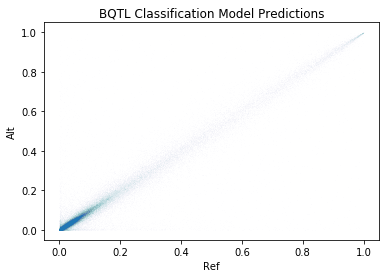

In [144]:
plt.scatter(bqtl_ref_classification_predictions_calibrated, bqtl_alt_classification_predictions_calibrated, s=0.1, alpha=0.01)
plt.xlabel("Ref")
plt.ylabel("Alt")
plt.title("BQTL Classification Model Predictions")
plt.show()


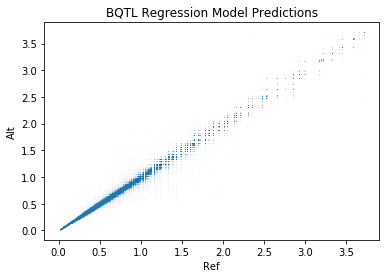

In [143]:
plt.scatter(bqtl_ref_regression_predictions_calibrated, bqtl_alt_regression_predictions_calibrated, s=0.1, alpha=0.01)
plt.xlabel("Ref")
plt.ylabel("Alt")
plt.title("BQTL Regression Model Predictions")
plt.show()

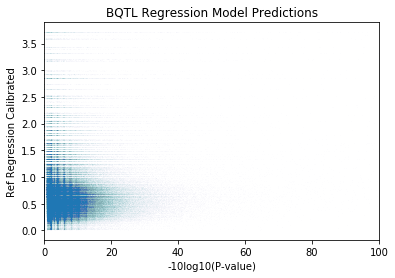

In [147]:
plt.scatter(-10*np.log10(bqtl_ref_classification_truth), bqtl_ref_regression_predictions_calibrated, s=0.1, alpha=0.01)
plt.xlabel("-10log10(P-value)")
plt.ylabel("Ref Regression Calibrated")
plt.title("BQTL Regression Model Predictions")
plt.xlim(0,100)
plt.show()

In [173]:
#save bqtl predictions 
chroms=[i[0] for i in bqtl_ref_gen.data.index]
pos=[i[1] for i in bqtl_ref_gen.data.index]
import h5py 
bqtl_predictions=h5py.File("SPI1.BQTL.predictions.hdf5",'w')
bqtl_predictions.create_dataset("bqtl_chrom",data=np.string_(chroms))
bqtl_predictions.create_dataset("bqtl_position",data=np.asarray(pos))
bqtl_predictions.create_dataset("bqtl_pvalue",data=bqtl_ref_gen.data['pvalue'])
bqtl_predictions.create_dataset("bqtl_classification_ref_preactivation",data=bqtl_ref_classification_logits)
bqtl_predictions.create_dataset("bqtl_classification_ref_postactivation",data=bqtl_ref_classification_predictions)
bqtl_predictions.create_dataset("bqtl_classification_ref_postactivation_calibrated",data=bqtl_ref_classification_predictions_calibrated)
bqtl_predictions.create_dataset("bqtl_classification_alt_preactivation",data=bqtl_alt_classification_logits)
bqtl_predictions.create_dataset("bqtl_classification_alt_postactivation",data=bqtl_alt_classification_predictions)
bqtl_predictions.create_dataset("bqtl_classification_alt_postactivation_calibrated",data=bqtl_alt_classification_predictions_calibrated)
bqtl_predictions.create_dataset("bqtl_regression_ref",data=bqtl_ref_regression_predictions)
bqtl_predictions.create_dataset("bqtl_regression_ref_calibrated",data=bqtl_ref_regression_predictions_calibrated)
bqtl_predictions.create_dataset("bqtl_regression_alt",data=bqtl_alt_regression_predictions)
bqtl_predictions.create_dataset("bqtl_regression_alt_calibrated",data=bqtl_alt_regression_predictions_calibrated)
bqtl_predictions.close() 


## Conclusions <a name='9'>
<a href=#outline>Home</a>

## Save tutorial outputs <a name='10'>
<a href=#outline>Home</a>

We save the models and test set predictions generated in this tutorial to an hdf5 file so that they can be loaded more readily in the future. 

In [175]:
#save the models 
spi1_classification_model.save("SPI1.classification.model.hdf5")
spi1_regression_model.save("SPI1.regression.model.hdf5")

#save the test predictions 
import h5py 
test_set_predictions=h5py.File("SPI1.test.predictions.hdf5",'w')
test_set_predictions.create_dataset("classification_labels",data=spi1_test_classification_truth)
test_set_predictions.create_dataset("classification_preactivation",data=spi1_test_classification_logits)
test_set_predictions.create_dataset("classification_postactivation",data=spi1_test_classification_predictions)
test_set_predictions.create_dataset("classification_postactivation_calibrated",data=spi1_test_classification_predictions_calibrated)
test_set_predictions.create_dataset("regression_labels",data=spi1_test_regression_truth)
test_set_predictions.create_dataset("regression",data=spi1_test_regression_predictions)
test_set_predictions.create_dataset("regression_calibrated",data=spi1_test_regression_predictions_calibrated)
test_set_predictions.close() 
